# Introduction

Everyone loves movies irrespective of age, gender, race, color, or geographical location. We all in a way that connected to each other via this amazing medium. Yet what most interesting is the fact that how unique our choices and combinations are in terms of movie preferences. Some people like genre-specific movies such as thriller, romance, or sci-fi, while others focus on leading actors and directors. In this project, We are interested in building a movie recommender system that uses several algorithms, including content-based algorithm, and collaborative filtering. Our recommender system is able to provide choices for people based on movies’ demographic features such as movie popularities, the genre of movies, the overview of the movie, and its crew and cast information to recommend a movie which is similar to the ones they like.

# 1.Data Source
We are using two datasets for the this project.


## 1.1 The Movie dataset
(https://www.kaggle.com/rounakbanik/the-movies-dataset/data?select=movies_metadata.csv)

The first movie dataset contains metadata for all 45,000 movies listed in the Full MovieLens Dataset. The dataset consists of movies released on or before July 2017. Data points include cast, crew, plot keywords, budget, revenue, posters, release dates, languages, production companies, countries, TMDB vote counts and vote averages.

This dataset also has files containing 26 million ratings from 270,000 users for all 45,000 movies. Ratings are on a scale of 1-5 and have been obtained from the official GroupLens website.

The second imdb dataset contains 85,855 movies on imdb. It includes move description, average rating, genre, number of votes, publish time and income. We use this data set because it has more features which can be used together with the first dataset. 

This dataset consists of the following files:

**movies_metadata.csv**: The main Movies Metadata file. Contains information on 45,000 movies featured in the Full MovieLens dataset. Features include posters, backdrops, budget, revenue, release dates, languages, production countries and companies.

**keywords.csv:** Contains the movie plot keywords for our MovieLens movies. Available in the form of a stringified JSON Object.

**credits.csv**: Consists of Cast and Crew Information for all our movies. Available in the form of a stringified JSON Object.

**links.csv**: The file that contains the TMDB and IMDB IDs of all the movies featured in the Full MovieLens dataset.

**links_small.csv**: Contains the TMDB and IMDB IDs of a small subset of 9,000 movies of the Full Dataset.

**ratings_small.csv**: The subset of 100,000 ratings from 700 users on 9,000 movies.



The Full MovieLens Dataset consisting of 26 million ratings and 750,000 tag applications from 270,000 users on all the 45,000 movies in this dataset can be accessed here

## 1.2 IMDb movies extensive dataset

 https://www.kaggle.com/stefanoleone992/imdb-extensive-dataset?select=IMDb+movies.csv 

IMDb is the most popular movie website and it combines movie plot description, Metastore ratings, critic and user ratings and reviews, release dates, and many more aspects.

The website is well know for storing almost every movie that has ever been released (the oldest is from 1874 - "Passage de Venus") or just planned to be released (newest movie is from 2027 - "Avatar 5").

IMDb stores information related to more than 6 million titles (of which almost 500,000 are featured films) and it is owned by Amazon since 1998.

**The movies dataset** includes 85,855 movies with attributes such as movie description, average rating, number of votes, genre, etc.

**The ratings dataset** includes 85,855 rating details from demographic perspective.

**The names dataset** includes 297,705 cast members with personal attributes such as birth details, death details, height, spouses, children, etc.

**The title principals dataset** includes 835,513 cast members roles in movies with attributes such as IMDb title id, IMDb name id, order of importance in the movie, role, and characters played.



# 2.Data Preprocessing
We need to rank movies based on their statistics. For example, we may need to take score of the movie, vote of the movie and many other factors into considerations when we rank the movie. We need to General Recommedation offers to every user based on movie popularity and (sometimes) genre. The basic idea behind this recommender is that movies that are more popular and more critically acclaimed will have a higher probability of being liked by the average audience. This model does not give personalized recommendations based on the user. 

The implementation of this model is extremely trivial. All we have to do is sort our movies based on ratings and popularity and display the top movies of our list. As an added step, we can pass in a genre argument to get the top movies of a particular genre. 

In [ ]:
# import all the necessary library
import pandas as pd
import numpy as np

In [ ]:
from google.colab import drive
# Mount google drive
DRIVE_MOUNT='/content/gdrive'
drive.mount(DRIVE_MOUNT)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


## 2.1 Load and Preprocess the Data
Now let's load our first dataset and take a look at it!

In [ ]:
movies_metadata_pd = pd.read_csv('/content/gdrive/MyDrive/recommendation system/the-movies-dataset/movies_metadata.csv')

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (10) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [ ]:
movies_metadata_pd.head(2)

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",21.9469,/rhIRbceoE9lR4veEXuwCC2wARtG.jpg,"[{'name': 'Pixar Animation Studios', 'id': 3}]","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,17.0155,/vzmL6fP7aPKNKPRTFnZmiUfciyV.jpg,"[{'name': 'TriStar Pictures', 'id': 559}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0


Now take a look at the type of each columns. 

In [ ]:
movies_metadata_pd.dtypes

adult                     object
belongs_to_collection     object
budget                    object
genres                    object
homepage                  object
id                        object
imdb_id                   object
original_language         object
original_title            object
overview                  object
popularity                object
poster_path               object
production_companies      object
production_countries      object
release_date              object
revenue                  float64
runtime                  float64
spoken_languages          object
status                    object
tagline                   object
title                     object
video                     object
vote_average             float64
vote_count               float64
dtype: object

First of all, we need to preprocess the **genres** . Since the original genres column contains a list of dictionary which includes genres id and name. We need to extract a list of genre name. We also notice that each element in this column is actually a string. we need a function to convert it to a list so that we can do list comprehenstion to extract name information. We can take advantage of the ast.literal_eval function to do this.

In [ ]:
from ast import literal_eval
movies_metadata_pd['genres_name'] = movies_metadata_pd['genres'].apply(literal_eval).apply(lambda x: [i['name'] for i in x] )

Now take a look at our dataset now. We have a new column named **genres_name**, which contains a list of genre.

In [ ]:
movies_metadata_pd[['genres','genres_name']].head(5)

,genres,genres_name
0,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...","[Animation, Comedy, Family]"
1,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...","[Adventure, Fantasy, Family]"
2,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...","[Romance, Comedy]"
3,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...","[Comedy, Drama, Romance]"
4,"[{'id': 35, 'name': 'Comedy'}]",[Comedy]


## 2.2 Calculate weighted rating

In this project, we will use the IMBD weighted rank score for the movie dataset. Here is what We found from IMBD website to describe how to calculate this score.

**"How do you calculate the rank of movies and TV shows on the Top 250 Rated Charts?**

The following formula is used to calculate the Top Rated 250 titles. This formula provides a true 'Bayesian estimate', which takes into account the number of votes each title has received, minimum votes required to be on the list, and the mean vote for all titles:

weighted rating (WR) = (v ÷ (v+m)) × R + (m ÷ (v+m)) × C

Where:

* R = average for the movie (mean) = (Rating)
* v = number of votes for the movie = (votes)
* m = minimum votes required to be listed in the Top 250 (currently 25,000)
* C = the mean vote across the whole report



---

Now take a look at the numerical and statistical feature of our dateset. We need to determine an appropriate value for *m*, the minimum votes required to be listed in the chart. We will use **90th percentile** as our cutoff. In other words, for a movie to feature in the charts, it must have more votes than at least 90% of the movies in the list. **m = 160**.

C is the mean vote across the whole report. **C =5.618207**

In [ ]:
movies_metadata_pd['vote_count'].quantile(0.9)

160.0

In [ ]:
movies_metadata_pd.describe()

,revenue,runtime,vote_average,vote_count
count,4.546000e+04,45203.000000,45460.000000,45460.000000
mean,1.120935e+07,94.128199,5.618207,109.897338
std,6.433225e+07,38.407810,1.924216,491.310374
min,0.000000e+00,0.000000,0.000000,0.000000
25%,0.000000e+00,85.000000,5.000000,3.000000
50%,0.000000e+00,95.000000,6.000000,10.000000
75%,0.000000e+00,107.000000,6.800000,34.000000
max,2.787965e+09,1256.000000,10.000000,14075.000000


For the recommender system, we first consider recommending films of high quality. So we will use this statistical features to filter our dataset

Therefore we get a small dataset, which contains 3789 movies. These films score above average and have at least 160 votes. We will use this small dataset for future processing.

In [ ]:
cleaned_mv_pd = movies_metadata_pd[(movies_metadata_pd['vote_average']>5.6) & (movies_metadata_pd['vote_count']>160)]
cleaned_mv_pd.describe()

,revenue,runtime,vote_average,vote_count
count,3.789000e+03,3789.000000,3789.000000,3789.000000
mean,1.085395e+08,109.942993,6.728372,1008.692267
std,1.895599e+08,26.761381,0.639351,1380.743259
min,0.000000e+00,0.000000,5.700000,161.000000
25%,3.000000e+06,96.000000,6.200000,262.000000
50%,3.976800e+07,107.000000,6.700000,472.000000
75%,1.252129e+08,121.000000,7.200000,1101.000000
max,2.787965e+09,705.000000,9.100000,14075.000000


In [ ]:
cleaned_mv_pd['weighted_rating'] = cleaned_mv_pd.apply(lambda x: (x['vote_count']/(x['vote_count']+160))*x['vote_average'] + (160/(x['vote_count']+160))*5.618207, axis=1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


## 2.3 Build Top movie charts
Now take a look at our Top 250 movies according to our weighted rating!

In [ ]:
movie_top_250 = cleaned_mv_pd[['title', 'release_date', 'vote_count', 'vote_average', 'popularity', 'genres_name','weighted_rating']].sort_values('weighted_rating', ascending=False).head(250)
movie_top_250.head(15)

,title,release_date,vote_count,vote_average,popularity,genres_name,weighted_rating
314,The Shawshank Redemption,1994-09-23,8358.0,8.5,51.6454,"[Drama, Crime]",8.445869
834,The Godfather,1972-03-14,6024.0,8.5,41.1093,"[Drama, Crime]",8.425439
10309,Dilwale Dulhania Le Jayenge,1995-10-20,661.0,9.1,34.457,"[Comedy, Drama, Romance]",8.421453
12481,The Dark Knight,2008-07-16,12269.0,8.3,123.167,"[Drama, Action, Crime, Thriller]",8.265477
2843,Fight Club,1999-10-15,9678.0,8.3,63.8696,[Drama],8.256385
292,Pulp Fiction,1994-09-10,8670.0,8.3,140.95,"[Thriller, Crime]",8.251406
522,Schindler's List,1993-11-29,4436.0,8.3,41.7251,"[Drama, History, War]",8.206639
23673,Whiplash,2014-10-10,4376.0,8.3,64.3,[Drama],8.205404
5481,Spirited Away,2001-07-20,3968.0,8.3,41.0489,"[Fantasy, Adventure, Animation, Family]",8.196055
2211,Life Is Beautiful,1997-12-20,3643.0,8.3,39.395,"[Comedy, Drama]",8.187171


# 3.Exploratory Data Analysis 

### 2.4.1 Which genre is the most popular among our top chart?
We want to study movie genre and its effect because people may like to watch movie of a specific genre which may be used in our recommender system. 

Is there any relationship between score and genre? Do audiences tend to give high marks (a movie tend to get high weighted score) based on certain types of films?

To confirm this, I have to explode genres_name column into separate columns for each genre. For example, The Shawshank Redemption is [Crime, Drama]. Then it will have "1" in the Crime column and Drama column and 0 for other columns. This is also known as one hot encoding. 

In [ ]:
onehot_data=movie_top_250[['genres_name']].explode('genres_name')
onehot_encoding = pd.get_dummies(onehot_data,prefix="",prefix_sep='')
onehot_encoding.reset_index(inplace=True)
onehot_encoding=onehot_encoding.rename(columns={"index": "film_index"})

onehot_encoding=onehot_encoding.groupby('film_index',as_index=False).sum()
onehot_encoding

,film_index,Action,Adventure,Animation,Comedy,Crime,Drama,Family,Fantasy,History,Horror,Music,Mystery,Romance,Science Fiction,Thriller,War,Western
0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0
1,5,1,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0
2,15,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0
3,46,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0
4,49,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
245,41540,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
246,42015,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0
247,42170,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0
248,43190,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0


In [ ]:
movie_top_250=movie_top_250.reset_index()
movie_top_250=movie_top_250.rename(columns={"index": "film_index"})
movie_top_250=movie_top_250.merge(onehot_encoding,on="film_index")

Now let's view our top 250 dataset again!

In [ ]:
movie_top_250.head()

,film_index,title,release_date,vote_count,vote_average,popularity,genres_name,weighted_rating,Action,Adventure,Animation,Comedy,Crime,Drama,Family,Fantasy,History,Horror,Music,Mystery,Romance,Science Fiction,Thriller,War,Western
0,314,The Shawshank Redemption,1994-09-23,8358.0,8.5,51.6454,"[Drama, Crime]",8.445869,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0
1,834,The Godfather,1972-03-14,6024.0,8.5,41.1093,"[Drama, Crime]",8.425439,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0
2,10309,Dilwale Dulhania Le Jayenge,1995-10-20,661.0,9.1,34.457,"[Comedy, Drama, Romance]",8.421453,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0
3,12481,The Dark Knight,2008-07-16,12269.0,8.3,123.167,"[Drama, Action, Crime, Thriller]",8.265477,1,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0
4,2843,Fight Club,1999-10-15,9678.0,8.3,63.8696,[Drama],8.256385,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0


We can plot the count for each genre in this dataset now!

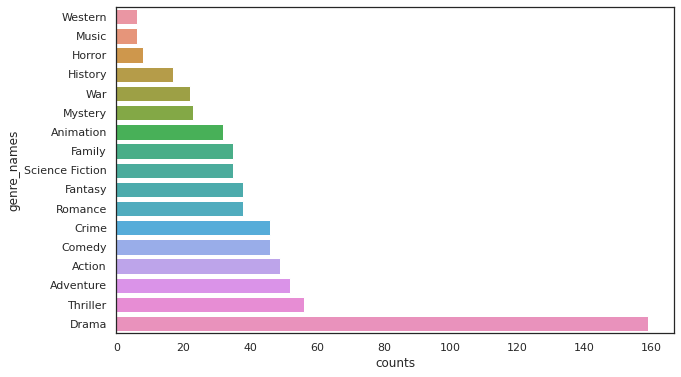

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(10,6))
genres_count = movie_top_250.sum()[7:,]
genres_count.name="counts"
genres_df=genres_count.to_frame().reset_index()
genres_df=genres_df.rename(columns={"index": "genre_names"})
genres_df
order1 =genres_df.sort_values('counts')
ax = sns.barplot(x=genres_df.counts,y=genres_df.genre_names,order=order1.genre_names)
#order1 = movie_top_250[['genres_name','weighted_rating']].groupby('genres_name').median().reset_index().sort_values('weighted_rating')
#ax = sns.boxplot(movie_top_250.genres_name, movie_top_250.weighted_rating)

**This plot above basically shows the count of each kind of films in top 250 films. Drama films are extremely higher than other genres with western be the least.**

<Figure size 1080x1080 with 0 Axes>

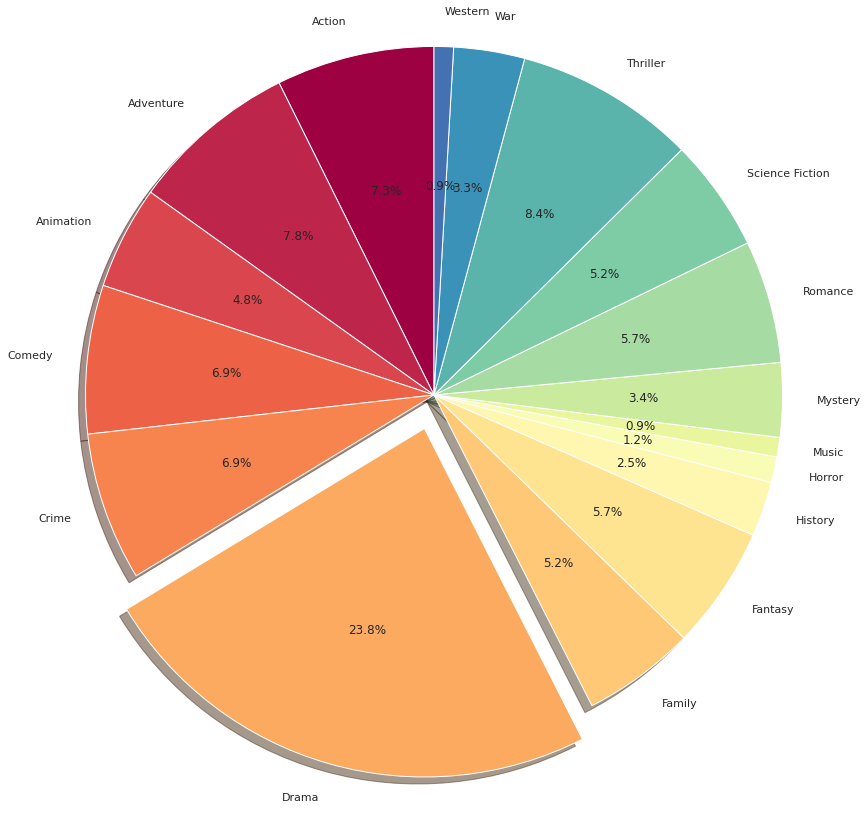

In [ ]:
plt.figure(figsize=(15,15))
fig1, ax1 = plt.subplots(figsize=(15,15))
cmap = plt.get_cmap('Spectral')
colors = [cmap(i) for i in np.linspace(0, 1, 18)]
explode = (0,0,0,0,0,0.1,0,0,0,0,0,0,0,0,0,0,0)
ax1.pie(genres_df.counts, explode=explode,labels=genres_df.genre_names, autopct='%1.1f%%',
        shadow=True, startangle=90,colors = colors)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

**This pie chart clearly showed that Drama films almost constitutes 1/4 of the  in top250 dataframe.**

Because we have two dataset and these two plots are made from the 1.1 Movie dataset. I also want to read the 1.2 dataset and make the same plot and see if these two can validate each other. 

In [ ]:
imdb_ratings = pd.read_csv('/content/gdrive/MyDrive/recommendation system/the-movies-dataset/IMDb ratings.csv')
imdb_ratings = imdb_ratings[['imdb_title_id','weighted_average_vote']]
imdb_ratings['imdb_title_id']=imdb_ratings['imdb_title_id'].apply(lambda x:x[2:])

imdb_id = pd.read_csv('/content/gdrive/MyDrive/recommendation system/the-movies-dataset/IMDb movies.csv')
imdb_id['imdb_title_id']=imdb_id['imdb_title_id'].apply(lambda x:x[2:])
imdb_title_ratings = imdb_id[["imdb_title_id","title","genre"]].merge(imdb_ratings,on="imdb_title_id")

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [ ]:
imdb_rating_top250=imdb_title_ratings.sort_values("weighted_average_vote",ascending=False).iloc[:250,]
imdb_rating_top250['genre']=imdb_rating_top250['genre'].apply(lambda x: list(x.split(', ')))
onehot_data=imdb_rating_top250[['genre']].explode('genre')
onehot_encoding = pd.get_dummies(onehot_data,prefix="",prefix_sep='')
onehot_encoding.reset_index(inplace=True)
onehot_encoding=onehot_encoding.rename(columns={"index": "film_index"})
onehot_encoding=onehot_encoding.groupby('film_index',as_index=False).sum()
onehot_encoding

,film_index,Action,Adventure,Animation,Biography,Comedy,Crime,Drama,Family,Fantasy,History,Horror,Music,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,5278,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0
1,8132,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
2,8457,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
3,8973,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0
4,10823,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
245,85590,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
246,85591,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0
247,85629,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
248,85678,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Here we make another top250 dataframe which is also the top 250 films with highest weighted ratings of imdb dataset. 

In [ ]:
imdb_rating_top250=imdb_rating_top250.reset_index()
imdb_rating_top250=imdb_rating_top250.rename(columns={"index": "film_index"})
imdb_rating_top250=imdb_rating_top250.merge(onehot_encoding,on="film_index")

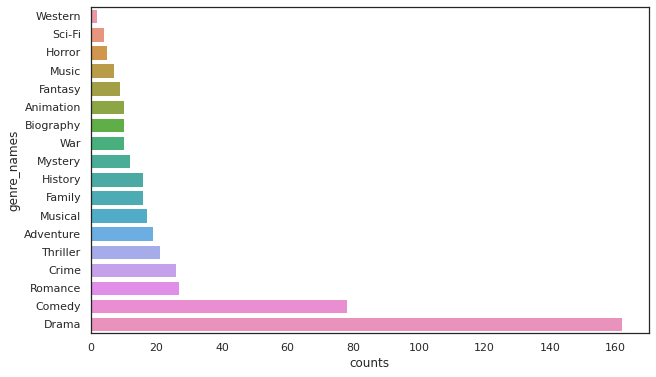

In [ ]:
plt.figure(figsize=(10,6))
genres_count = imdb_rating_top250.sum()[6:,]
genres_count.name="counts"
genres_df=genres_count.to_frame().reset_index()
genres_df=genres_df.rename(columns={"index": "genre_names"})
genres_df
order1 =genres_df.sort_values('counts')
ax = sns.barplot(x=genres_df.counts,y=genres_df.genre_names,order=order1.genre_names)

<Figure size 1080x1080 with 0 Axes>

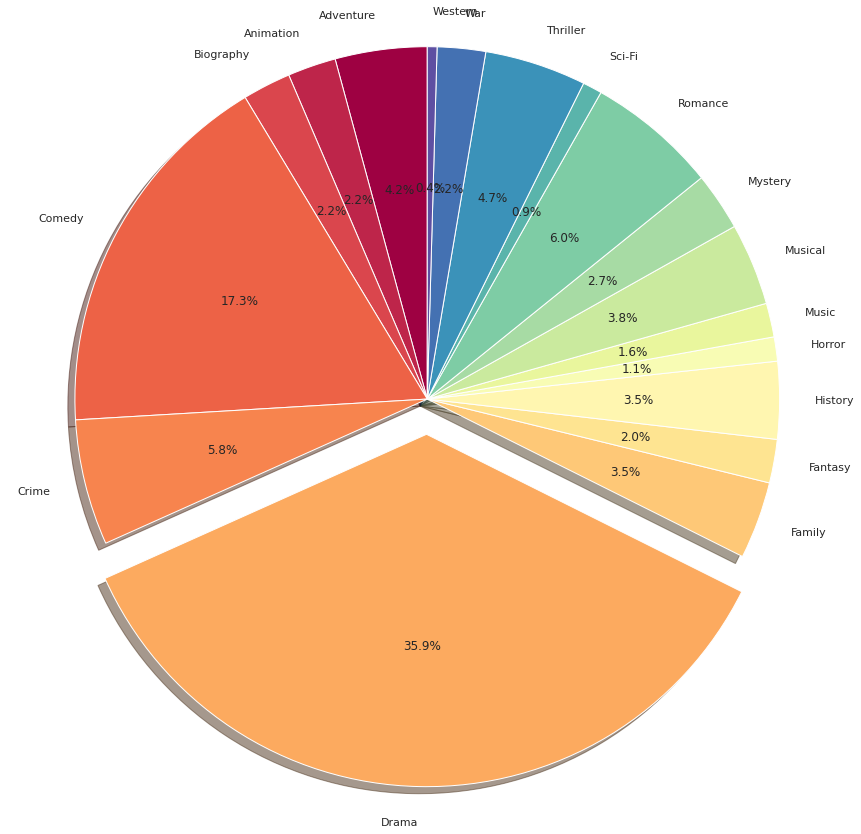

In [ ]:
plt.figure(figsize=(15,15))
fig1, ax1 = plt.subplots(figsize=(15,15))
cmap = plt.get_cmap('Spectral')
colors = [cmap(i) for i in np.linspace(0, 1, 18)]
explode = (0,0,0,0,0,0.1,0,0,0,0,0,0,0,0,0,0,0,0)
ax1.pie(genres_df.counts, explode=explode,labels=genres_df.genre_names, autopct='%1.1f%%',
        shadow=True, startangle=90,colors = colors)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

**Here, we can see two datasets share some common features. Drama is the No.1 in both dataset, which means among all the genres, drama likely to have high ratings. In both dataset, Comedy, Romance, Crime, Thriller, Comedy and Action films ranked after drama. They are all genres that have good ratings. These results is generated by counting the total number of films for each genre in top250 dataframe.**

### 2.4.2 Whether a movie is likely to get higher score based on its genre?
Is there any relationship between score and genre? Do audiences tend to give high marks (a movie tend to get high weighted score) based on certain types of films?

In this part, we continue to use top 250 dataset. 

(7.0, 8.0)

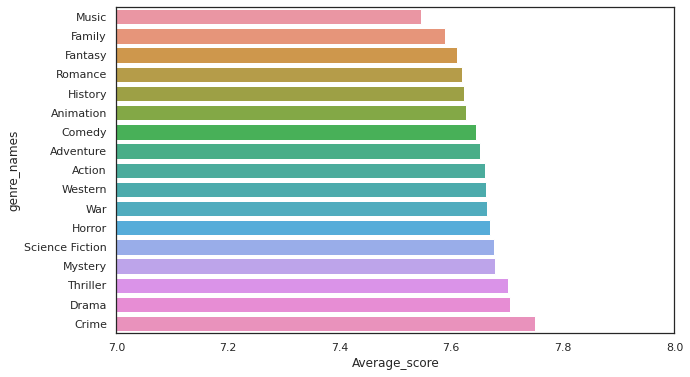

In [ ]:
plt.figure(figsize=(10,6))
genre_name = ['Action','Adventure',"Animation","Comedy","Crime", "Drama","Family","Fantasy","History","Horror","Music","Mystery","Romance",\
              "Science Fiction", "Thriller","War","Western"]
dictionary={}
for i in genre_name:
  dictionary[i]=movie_top_250['weighted_rating'].loc[movie_top_250[i] == 1].mean()

genres_score_df=pd.DataFrame.from_dict(dictionary,orient='index',columns=['Average_score'])
genres_score_df.reset_index(inplace=True)
genres_score_df=genres_score_df.rename(columns={"index": "genre_names"})
order1 =genres_score_df.sort_values('Average_score')
ax = sns.barplot(y=genres_score_df.genre_names, x=genres_score_df.Average_score,order=order1.genre_names)
plt.xlim((7, 8))

**This plot shows average weighted ratings for each genres in top 250 films. The range is small, from 7.5 to 7.8 because this dataset is for top 250 films with highest ratings. Crime seems to have higher scores and music seems to have lower scores. In previous discussion we found that drama films make up a big part in 250 films and it has the second highest scores. Maybe drama movies are appealing to people in all ages and likely to get higher ratings.**





Now I want to make the same plot for imdb_rating_top250 and see if this gives similar result. 

(8.0, 10.0)

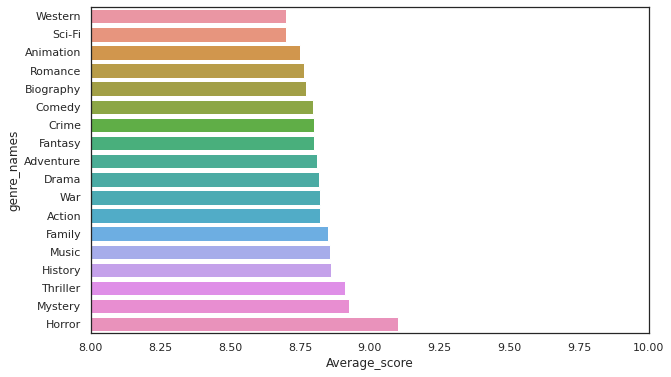

In [ ]:
plt.figure(figsize=(10,6))
genre_name = ['Action','Adventure',"Animation","Biography","Comedy","Crime", "Drama","Family","Fantasy","History","Horror","Music","Mystery","Romance",\
              "Sci-Fi", "Thriller","War","Western"]
dictionary={}
for i in genre_name:
  dictionary[i]=imdb_rating_top250['weighted_average_vote'].loc[imdb_rating_top250[i] == 1].mean()

genres_score_df=pd.DataFrame.from_dict(dictionary,orient='index',columns=['Average_score'])
genres_score_df.reset_index(inplace=True)
genres_score_df=genres_score_df.rename(columns={"index": "genre_names"})
order1 =genres_score_df.sort_values('Average_score')
ax = sns.barplot(y=genres_score_df.genre_names, x=genres_score_df.Average_score,order=order1.genre_names)
plt.xlim((8, 10))

**This is a little bit different from previous plot. Crime is the No.1 for the movies dataset and here Horror is the No.1 for imdb dataset. However, Horror, Mystery and Thriller are in top5 in both plot. Although these two datasets use different algorithm to get averaged ratings, they still share some similarities. Drama does not rank at the top but its average rating is above 8.75 which is not bad.**

### 2.4.3 Which kind of movie has higher income? 

Movie income is also important for our recommender system. People probably choose to watch movies that other people like.

Is there any relationship between income and genre? Which genre usually has higher budget? Which genre require less budget but generate higher income?

Here we continue using IMDB dataset, which has film title, imdb film id, genres, director, budget, income, common review and critic reviews. 

Let's read this file again and have a look. 

In [ ]:
imdb_id=imdb_id.drop(columns={'original_title', 'metascore','avg_vote','votes'})
imdb_id['budget']=imdb_id['budget'].astype('str')
imdb_id=imdb_id.dropna(axis=0)
imdb_id=imdb_id.loc[imdb_id['budget'].str.split().str[0]=="$"]
imdb_id.head()

,imdb_title_id,title,year,date_published,genre,duration,country,language,director,writer,production_company,actors,description,budget,usa_gross_income,worlwide_gross_income,reviews_from_users,reviews_from_critics
165,0010323,Il gabinetto del dottor Caligari,1920,1920-02-27,"Fantasy, Horror, Mystery",76,Germany,German,Robert Wiene,"Carl Mayer, Hans Janowitz",Decla-Bioscop AG,"Werner Krauss, Conrad Veidt, Friedrich Feher, ...","Hypnotist Dr. Caligari uses a somnambulist, Ce...",$ 18000,$ 8811,$ 8811,237.0,160.0
245,0012190,I quattro cavalieri dell'Apocalisse,1921,1923-04-16,"Drama, Romance, War",150,USA,None,Rex Ingram,"Vicente Blasco Ibáñez, June Mathis",Metro Pictures Corporation,"Pomeroy Cannon, Josef Swickard, Bridgetta Clar...",An extended family split up in France and Germ...,$ 800000,$ 9183673,$ 9183673,45.0,16.0
1048,0021749,Luci della città,1931,1931-04-02,"Comedy, Drama, Romance",87,USA,English,Charles Chaplin,Charles Chaplin,Charles Chaplin Productions,"Virginia Cherrill, Florence Lee, Harry Myers, ...","With the aid of a wealthy erratic tippler, a d...",$ 1500000,$ 19181,$ 46008,295.0,122.0
2454,0027977,Tempi moderni,1936,1937-03-12,"Comedy, Drama, Family",87,USA,English,Charles Chaplin,Charles Chaplin,Charles Chaplin Productions,"Charles Chaplin, Paulette Goddard, Henry Bergm...",The Tramp struggles to live in modern industri...,$ 1500000,$ 163577,$ 457688,307.0,115.0
2795,0029453,Il bandito della Casbah,1937,1937-10-22,"Crime, Drama, Romance",94,France,"French, Arabic",Julien Duvivier,"Henri La Barthe, Henri La Barthe",Paris Film,"Jean Gabin, Gabriel Gabrio, Saturnin Fabre, Fe...",A wanted gangster is both king and prisoner of...,$ 60000,$ 155895,$ 155895,46.0,55.0


This dataset has some useful columns that the first dataset doesn't have, such as budget, income, production_company and publish year. 

There is another file called ratings.csv which describes the user rating for each movieid with a timestamp column. We can join these two data together on the movieId column, which is a specific 7-digits number. 

In [ ]:
#read a ratings file and create a new column for the number of reviews for each film and a column for average rating for each film. 
ratings=pd.read_csv('/content/gdrive/MyDrive/recommendation system/the-movies-dataset/ratings.csv',dtype={"movieId":str})
ratings['movieId'] =ratings['movieId'].str.zfill(7)
ratings['rating_count'] = ratings.groupby('movieId')['userId'].transform('count')
ratings['rating_average'] = ratings.groupby('movieId')['rating'].transform('mean')
ratings=ratings.drop(columns={'userId'})
ratings.drop_duplicates('movieId')
ratings=ratings.drop(columns={'rating'})
ratings.head()

,movieId,timestamp,rating_count,rating_average
0,0000110,1425941529,66512,4.016057
1,0000147,1425942435,4967,3.595933
2,0000858,1425941523,57070,4.339811
3,0001221,1425941546,36679,4.263475
4,0001246,1425941556,25752,3.912803


Let's merge them together and call it ratings_new!

In [ ]:
ratings_new=imdb_id.merge(ratings,left_on="imdb_title_id", right_on="movieId")
ratings_new.drop_duplicates('movieId', inplace=True)
ratings_new['worlwide_gross_income']=ratings_new['worlwide_gross_income'].apply(lambda x:x[1:]).astype('int')
ratings_new['usa_gross_income']=ratings_new['usa_gross_income'].apply(lambda x:x[1:]).astype('int')
ratings_new['budget']=ratings_new['budget'].astype('str')
ratings_new['budget']=ratings_new['budget'].str.extract('(\d+)')
ratings_new['budget']=ratings_new['budget'].astype('int')
ratings_new.head()

,imdb_title_id,title,year,date_published,genre,duration,country,language,director,writer,production_company,actors,description,budget,usa_gross_income,worlwide_gross_income,reviews_from_users,reviews_from_critics,movieId,timestamp,rating_count,rating_average
0,0034583,Casablanca,1942,1946-11-21,"Drama, Romance, War",102,USA,"English, French, German, Italian",Michael Curtiz,"Julius J. Epstein, Philip G. Epstein",Warner Bros.,"Humphrey Bogart, Ingrid Bergman, Paul Henreid,...",A cynical American expatriate struggles to dec...,950000,4108411,4374761,1303.0,196.0,0034583,1269345248,74,3.324324
74,0038499,Duello al sole,1946,1948-11-18,"Drama, Romance, Western",129,USA,English,"King Vidor, Otto Brower","David O. Selznick, Niven Busch",Selznick International Pictures,"Jennifer Jones, Joseph Cotten, Gregory Peck, L...",Beautiful half-breed Pearl Chavez becomes the ...,8000000,20408163,20428771,101.0,46.0,0038499,1435829934,592,3.846284
666,0043014,Viale del tramonto,1950,1951-03-06,"Drama, Film-Noir",110,USA,English,Billy Wilder,"Charles Brackett, Billy Wilder",Paramount Pictures,"William Holden, Gloria Swanson, Erich von Stro...",A screenwriter develops a dangerous relationsh...,1752000,299645,299645,615.0,178.0,0043014,1501191806,30,2.900000
696,0043899,Pandora,1951,1951-02-01,"Drama, Fantasy, Mystery",122,UK,"English, Spanish",Albert Lewin,Albert Lewin,Dorkay Productions,"James Mason, Ava Gardner, Nigel Patrick, Sheil...",A seductive woman falls in love with a mysteri...,1500000,17401,31805,50.0,45.0,0043899,1374240304,82,3.725610
778,0046912,Il delitto perfetto,1954,1954-11-19,"Crime, Thriller",105,USA,English,Alfred Hitchcock,"Frederick Knott, Frederick Knott",Warner Bros.,"Ray Milland, Grace Kelly, Robert Cummings, Joh...",A tennis player tries to arrange his wife's mu...,1400000,12562,18816,356.0,107.0,0046912,1250773068,43,3.116279


Before exploring the columns, let's make a correlation plot of all columns in ratings_new dataframe. 

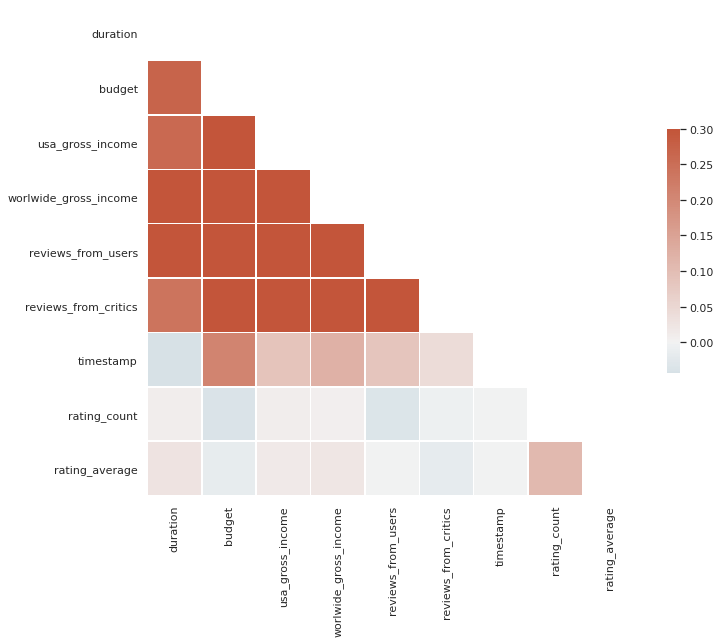

In [ ]:
#correlation plot
from string import ascii_letters
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="white")
corr = ratings_new.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

**We can conclude that several columns correlated with others in ratings_new dataframe. It is easy to understand some correlations here. For example, movies with high budgets always have high US and worldwide income. These movies also have more reviews from users and critics.**

Now I want to extract top 500 films with highest worldwide income. 

In [ ]:
worldwide_income_top500=ratings_new.sort_values('worlwide_gross_income',ascending=False).iloc[0:500]
worldwide_income_top500['genre']=worldwide_income_top500['genre'].apply(lambda x: list(x.split(', ')))
worldwide_income_top500.head()

,imdb_title_id,title,year,date_published,genre,duration,country,language,director,writer,production_company,actors,description,budget,usa_gross_income,worlwide_gross_income,reviews_from_users,reviews_from_critics,movieId,timestamp,rating_count,rating_average
68380,0167260,Il Signore degli Anelli - Il ritorno del re,2003,2004-01-22,"[Action, Adventure, Drama]",201,"New Zealand, USA","English, Quenya, Old English, Sindarin",Peter Jackson,"J.R.R. Tolkien, Fran Walsh",New Line Cinema,"Noel Appleby, Ali Astin, Sean Astin, David Ast...",Gandalf and Aragorn lead the World of Men agai...,94000000,377845905,1142271098,3718.0,353.0,0167260,1482026356,2,4.0
67856,0120915,Star Wars: Episodio I - La minaccia fantasma,1999,1999-09-17,"[Action, Adventure, Fantasy]",136,USA,English,George Lucas,George Lucas,Lucasfilm,"Liam Neeson, Ewan McGregor, Natalie Portman, J...",Two Jedi escape a hostile blockade to find all...,115000000,474544677,1027082707,3856.0,359.0,0120915,1478909835,1,0.5
68060,0145487,Spider-Man,2002,2002-06-07,"[Action, Adventure, Sci-Fi]",121,USA,English,Sam Raimi,"Stan Lee, Steve Ditko",Columbia Pictures,"Tobey Maguire, Willem Dafoe, Kirsten Dunst, Ja...","When bitten by a genetically modified spider, ...",139000000,407022860,825025036,2130.0,322.0,0145487,1458327613,5,3.3
68382,0167404,The Sixth Sense - Il sesto senso,1999,1999-10-29,"[Drama, Mystery, Thriller]",107,USA,"English, Latin, Spanish",M. Night Shyamalan,M. Night Shyamalan,Hollywood Pictures,"Bruce Willis, Haley Joel Osment, Toni Collette...",A boy who communicates with spirits seeks the ...,40000000,293506292,672806292,2233.0,265.0,0167404,1482493506,1,4.5
67313,0119567,Il mondo perduto - Jurassic Park,1997,1997-09-05,"[Action, Adventure, Sci-Fi]",129,USA,"English, Spanish",Steven Spielberg,"Michael Crichton, David Koepp",Universal Pictures,"Jeff Goldblum, Julianne Moore, Pete Postlethwa...",A research team is sent to the Jurassic Park S...,73000000,229086679,618638999,664.0,206.0,0119567,1467729240,15,3.7


Let's do the one-hot encoding again.

In [ ]:
#one hot encode top 500 films in gross world wide income
onehot_data=worldwide_income_top500[['genre']].explode('genre')
onehot_encoding = pd.get_dummies(onehot_data,prefix="",prefix_sep='')
onehot_encoding.reset_index(inplace=True)
onehot_encoding=onehot_encoding.rename(columns={"index": "film_index"})

onehot_encoding=onehot_encoding.groupby('film_index',as_index=False).sum()
worldwide_income_top500=worldwide_income_top500.reset_index()
worldwide_income_top500=worldwide_income_top500.rename(columns={"index": "film_index"})
worldwide_income_top500=worldwide_income_top500.merge(onehot_encoding,on="film_index")
worldwide_income_top500.drop(columns='genre', inplace=True)
worldwide_income_top500.head()

,film_index,imdb_title_id,title,year,date_published,duration,country,language,director,writer,production_company,actors,description,budget,usa_gross_income,worlwide_gross_income,reviews_from_users,reviews_from_critics,movieId,timestamp,rating_count,rating_average,Action,Adventure,Animation,Biography,Comedy,Crime,Drama,Family,Fantasy,History,Horror,Music,Musical,Mystery,Romance,Sci-Fi,Sport,Thriller,War,Western
0,68380,0167260,Il Signore degli Anelli - Il ritorno del re,2003,2004-01-22,201,"New Zealand, USA","English, Quenya, Old English, Sindarin",Peter Jackson,"J.R.R. Tolkien, Fran Walsh",New Line Cinema,"Noel Appleby, Ali Astin, Sean Astin, David Ast...",Gandalf and Aragorn lead the World of Men agai...,94000000,377845905,1142271098,3718.0,353.0,0167260,1482026356,2,4.0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,67856,0120915,Star Wars: Episodio I - La minaccia fantasma,1999,1999-09-17,136,USA,English,George Lucas,George Lucas,Lucasfilm,"Liam Neeson, Ewan McGregor, Natalie Portman, J...",Two Jedi escape a hostile blockade to find all...,115000000,474544677,1027082707,3856.0,359.0,0120915,1478909835,1,0.5,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
2,68060,0145487,Spider-Man,2002,2002-06-07,121,USA,English,Sam Raimi,"Stan Lee, Steve Ditko",Columbia Pictures,"Tobey Maguire, Willem Dafoe, Kirsten Dunst, Ja...","When bitten by a genetically modified spider, ...",139000000,407022860,825025036,2130.0,322.0,0145487,1458327613,5,3.3,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
3,68382,0167404,The Sixth Sense - Il sesto senso,1999,1999-10-29,107,USA,"English, Latin, Spanish",M. Night Shyamalan,M. Night Shyamalan,Hollywood Pictures,"Bruce Willis, Haley Joel Osment, Toni Collette...",A boy who communicates with spirits seeks the ...,40000000,293506292,672806292,2233.0,265.0,0167404,1482493506,1,4.5,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0
4,67313,0119567,Il mondo perduto - Jurassic Park,1997,1997-09-05,129,USA,"English, Spanish",Steven Spielberg,"Michael Crichton, David Koepp",Universal Pictures,"Jeff Goldblum, Julianne Moore, Pete Postlethwa...",A research team is sent to the Jurassic Park S...,73000000,229086679,618638999,664.0,206.0,0119567,1467729240,15,3.7,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0


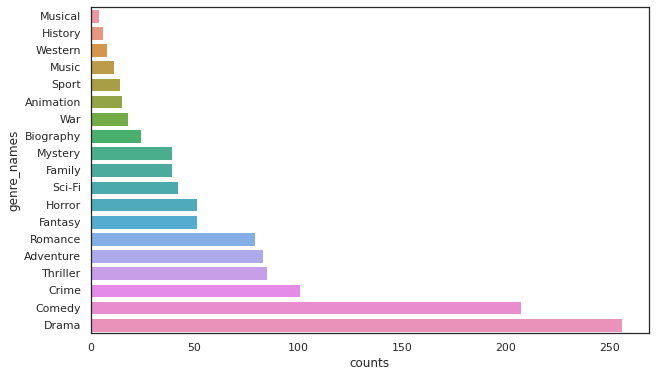

In [ ]:
#plot the counts of different movie genres in worldwide_income_top500
plt.figure(figsize=(10,6))
genres_count = worldwide_income_top500.sum()[23:,]
genres_count.name="counts"
genres_df=genres_count.to_frame().reset_index()
genres_df=genres_df.rename(columns={"index": "genre_names"})

order1 =genres_df.sort_values('counts')
ax = sns.barplot(y=genres_df.genre_names, x=genres_df.counts,order=order1.genre_names)


**In top 500 films of highest world wide income, drama films are the most, followed with comedy and Crime films. Musical, History and Western films seem to have least incomes among all genres. Although this result is a little bit different from previous dataset of top 250 films with highest weighted ratings, drama is still the No.1 genre.**

We can also plot the average world wide income for each genre in top 500 films. 

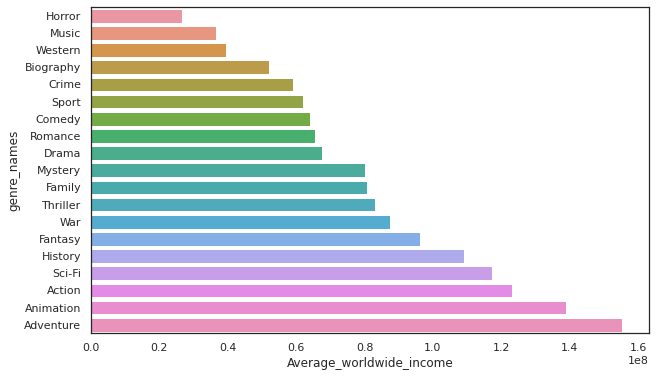

In [ ]:
#plot the average world wide income for each genre in top 500 films
plt.figure(figsize=(10,6))
genre_name = ['Action','Adventure',"Animation","Biography","Comedy","Crime", "Drama","Family","Fantasy","History","Horror","Music","Mystery","Romance",\
              "Sci-Fi","Sport","Thriller","War","Western"]
dictionary={}
for i in genre_name:
  dictionary[i]=worldwide_income_top500['worlwide_gross_income'].loc[worldwide_income_top500[i] == 1].mean()

genres_score_df=pd.DataFrame.from_dict(dictionary,orient='index',columns=['Average_worldwide_income'])
genres_score_df.reset_index(inplace=True)
genres_score_df=genres_score_df.rename(columns={"index": "genre_names"})
order1 =genres_score_df.sort_values('Average_worldwide_income')
ax = sns.barplot(y=genres_score_df.genre_names, x=genres_score_df.Average_worldwide_income,order=order1.genre_names)

**This plot illustrated the relationship between average world wide income and movie genres, which probably more convincing than movie counts. Adventure, Animation and Action films have the highest income around 0.1 billion. Horror and Music have the lowest income which is around 2 million. Although Drama films have many seats in top 500 films, Adventure films has the highest average of income, which is interesting. Recall that Horror films have highest average ratings but here with lowest income. It proves that movies with good ratings may not have good income.**

###2.4.4 Which movie genre has the highest budget and which genre use less money but generate more income?

This is probably the most important question for investors. Sometimes, good movies with high ratings cannot generate high income. Movies with high income may not have good ratings. Here we continue using top500 dataset and one-hot encoding to make some plots. 

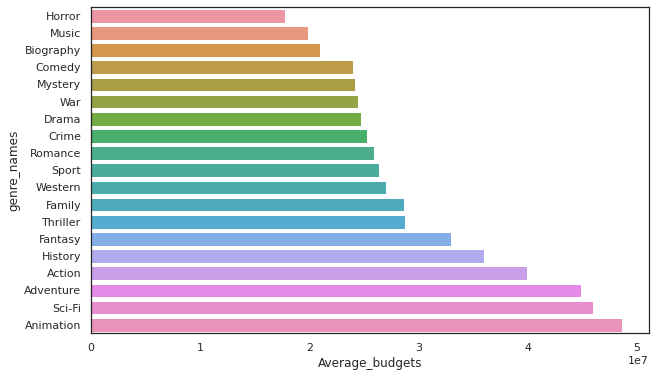

In [ ]:
#plot the average budget for each genre
plt.figure(figsize=(10,6))
genre_name = ['Action','Adventure',"Animation","Biography","Comedy","Crime", "Drama","Family","Fantasy","History","Horror","Music","Mystery","Romance",\
              "Sci-Fi","Sport","Thriller","War","Western"]
worldwide_income_top500['budget']=worldwide_income_top500['budget'].astype('float')
dictionary={}
for i in genre_name:
  dictionary[i]=worldwide_income_top500['budget'].loc[worldwide_income_top500[i] == 1].mean()

genres_score_df=pd.DataFrame.from_dict(dictionary,orient='index',columns=['Average_budgets'])
genres_score_df.reset_index(inplace=True)
genres_score_df=genres_score_df.rename(columns={"index": "genre_names"})
order1 =genres_score_df.sort_values('Average_budgets')
ax = sns.barplot(y = genres_score_df.genre_names, x =genres_score_df.Average_budgets,order=order1.genre_names)


**This plot showed that Animation films, Sci-Fi and Adventure films have highest budgest, while Horror films, Music and Biography films have the lowest budget. This makes sense because Animation, Sci-Fi and Adventure films need to set up many scenes for filming and thus need a lot of CG effect which are expensive.**

Then, let's make a new column of income/budget for each film and make a plot of average income-budget for each genre. Here we make a new column which is generated by subtract budget from income. 

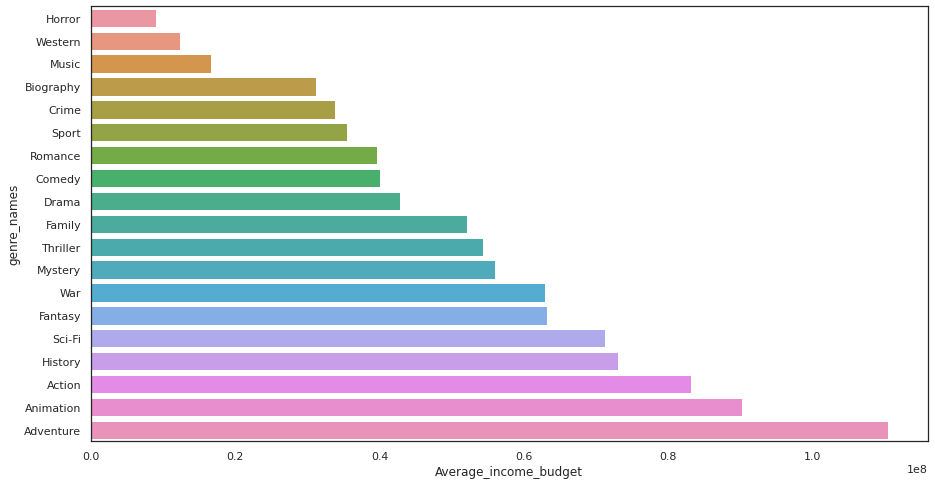

In [ ]:
#plot income versus budget for each genre in top 500
worldwide_income_top500['worlwide_gross_income']=worldwide_income_top500['worlwide_gross_income'].astype('int')
worldwide_income_top500['budget']=worldwide_income_top500['budget'].astype('int')
worldwide_income_top500['income_budget']=worldwide_income_top500['worlwide_gross_income']-worldwide_income_top500['budget']
worldwide_income_top500
genre_name = ['Action','Adventure',"Animation","Biography","Comedy","Crime", "Drama","Family","Fantasy","History","Horror","Music","Mystery","Romance",\
              "Sci-Fi","Sport","Thriller","War","Western"]
plt.figure(figsize=(15,8))
dictionary={}
for i in genre_name:
  dictionary[i]=worldwide_income_top500['income_budget'].loc[worldwide_income_top500[i] == 1].mean()

genres_score_df=pd.DataFrame.from_dict(dictionary,orient='index',columns=['Average_income_budget'])
genres_score_df.reset_index(inplace=True)
genres_score_df=genres_score_df.rename(columns={"index": "genre_names"})
order1 =genres_score_df.sort_values('Average_income_budget')
ax = sns.barplot(y =genres_score_df.genre_names, x = genres_score_df.Average_income_budget,order=order1.genre_names)



**This plot showed that Adventure films, Animation films and Action films have the highest value for investment. Because they have higher income - budget. Horror, Western and Music films are probably the worst choices here. We noticed that Horror, Western, and Biography ranked at the bottom in many plots we made till now, which means only few people like watching these genres.**

### 2.4.5 Which is the best production company?

This question is also important for the recommender system because many people prefer to watch movies produced by the same company. For example, many Marvel and DC fans watch every movie published by these companies. 

Here we continue using top500 dataset and see which company produced most films in this dataset. 

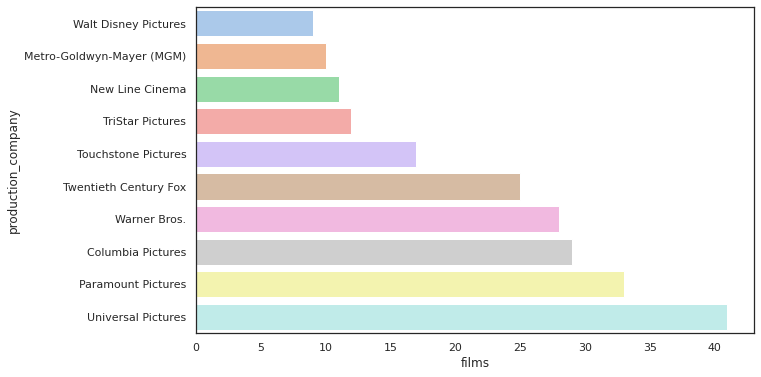

In [ ]:
#Plot the production companies that produced most films in top 500. 
Best_company=worldwide_income_top500.groupby('production_company').count().sort_values('film_index', ascending=False).reset_index()[['production_company','film_index']]
Best_company=Best_company.rename(columns={'film_index':'films'})
Best_company=Best_company.iloc[:10,]
Best_company
plt.figure(figsize=(10,6))
order1=Best_company.sort_values('films')
ax = sns.barplot(y = Best_company.production_company, x = Best_company.films,order=order1.production_company,palette="pastel")

**These ten companies produced most films in top 500 and Universal Pictures is the best. They are all big companies that we are familiar with. It looks like big companies tend to make movies with higher incomes.**

### 2.4.6 Which year is the best year for movie industry?

This dataset includes films from 1984 to 2027. Of course we dropped all films with null in income column. We are not using top500 dataset here. Instead, we use the whole imdb dataframe to see which year published the most films. 




/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


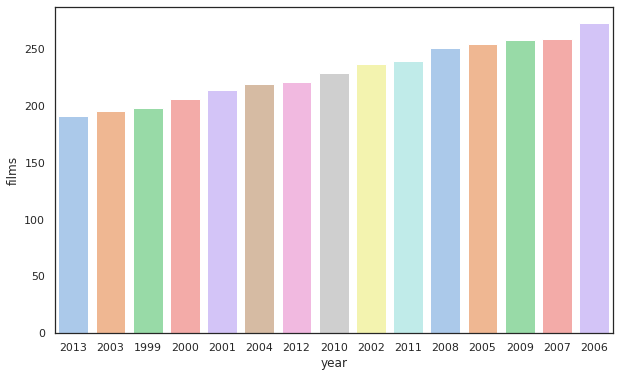

In [ ]:
#let's plot the number of films in each year for top 500
Best_year = imdb_id.groupby('year').count().sort_values('imdb_title_id', ascending=False).reset_index().reset_index()[['year','imdb_title_id']]
Best_year=Best_year.rename(columns={'imdb_title_id':'films'})
Best_year=Best_year.iloc[:15,]
plt.figure(figsize=(10,6))
order1=Best_year.sort_values('films')
ax = sns.barplot(Best_year.year, Best_year.films,order=order1.year,palette="pastel")

**2006 has most number of films and that maybe the best year for movie industry. Here I used the whole imdb file rather than top500. This is the total number of films that released each year and have nothing about worldwide income.**

### 2.4.7 WordCloud for top500 and last500 films of worldwide income

The description column is the summary of films and we want to see which word exist most. To some extent, it may give us the answer of people's interests in movies. 

In [ ]:
top500_content = worldwide_income_top500['description'].to_list()
worldwide_income_last500=imdb_id.sort_values('worlwide_gross_income',ascending=True).iloc[0:500]
last500_content = worldwide_income_last500['description'].to_list()

In [ ]:
import nltk
from nltk.corpus import stopwords
import nltk
nltk.download('punkt')
nltk.download('stopwords')
stopwords = set(stopwords.words('english')) 

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
def tokenize_content(content):
  """returns tokenized string

  :param content: text string
  :return: tokenized text/list of words
  """
  tok = nltk.word_tokenize(content)
  list = []
  for word in tok:
    if word.isalpha()==True:
      words = word.lower()
      if words not in stopwords:
        list.append(words)

  return list

In [ ]:
top500_tokens = [tokenize_content(x) for x in top500_content]
alltop500_tokens = []
for i in range(0, len(top500_tokens)):
  for j in range(0, len(top500_tokens[i])):
    alltop500_tokens.append(top500_tokens[i][j])
from collections import Counter
top500_counter = Counter(alltop500_tokens)
top500_most_common = top500_counter.most_common(20)

In [ ]:
last500_tokens = [tokenize_content(x) for x in last500_content]
alllast500_tokens = []
for i in range(0, len(last500_tokens)):
  for j in range(0, len(last500_tokens[i])):
    alllast500_tokens.append(last500_tokens[i][j])
from collections import Counter
last500_counter = Counter(alllast500_tokens)
last500_most_common = last500_counter.most_common(20)

In [ ]:
last500_most_common

[('life', 55),
 ('young', 52),
 ('new', 45),
 ('two', 43),
 ('man', 42),
 ('woman', 41),
 ('family', 40),
 ('one', 31),
 ('find', 29),
 ('must', 28),
 ('school', 27),
 ('finds', 26),
 ('friends', 25),
 ('group', 23),
 ('daughter', 22),
 ('story', 22),
 ('wife', 22),
 ('boy', 21),
 ('world', 21),
 ('city', 21)]

In [ ]:
def distinct_highest_counter(high, low):
  list1=Counter(high)
  list2=Counter(low)
  list1.subtract(list2)
  return list1

In [ ]:
distinct_highest_common = distinct_highest_counter(alltop500_tokens,alllast500_tokens)


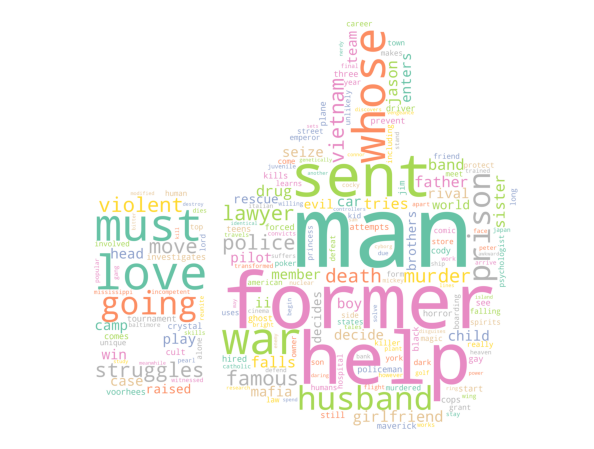

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
mask = np.array(Image.open('/content/gdrive/MyDrive/recommendation system/the-movies-dataset/upvote.png'))



highest_wordcloud = WordCloud(width = 3000, height = 2000, random_state=1, background_color='white', colormap='Set2', collocations=False,\
                              stopwords=stopwords,mask=mask).generate_from_frequencies(dict(distinct_highest_common))
plt.figure(figsize=(15,8))
plt.imshow(highest_wordcloud)
plt.axis("off")
plt.show()
plt.close()

**This is a word cloud of commonly seen words in description of top 500 films. Some of them are "love", "husband", "help", "war", which can let you have a basic feeling of what the movie is.**

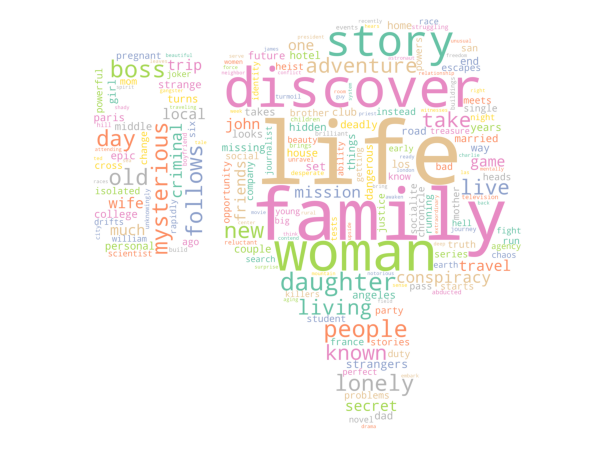

In [ ]:
mask = np.array(Image.open('/content/gdrive/MyDrive/recommendation system/the-movies-dataset/downvote.png'))
low_fig = distinct_highest_counter(alllast500_tokens,alltop500_tokens)
lowest_wordcloud = WordCloud(width = 3000, height = 2000, random_state=1, background_color='white', colormap='Set2', collocations=False,\
                              stopwords=stopwords,mask=mask).generate_from_frequencies(dict(low_fig))
plt.figure(figsize=(15,8))
plt.imshow(lowest_wordcloud)
plt.axis("off")
plt.show()
plt.close()

**This is a word cloud of most commonly seen words for last 500 films. Some of the words are "discover", "story", "mission", "mysterious". So, maybe people don't like films about a mysterious discovery.**

### 2.4.8 Which director has directed the most works in our top chart?

In [ ]:
credits = pd.read_csv('/content/gdrive/MyDrive/recommendation system/the-movies-dataset/credits.csv')

In [ ]:
cleaned_mv_pd['id'] = cleaned_mv_pd['id'].astype('int')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
mv_pd_2_3_3 = cleaned_mv_pd.merge(credits,on='id')

In [ ]:
import numpy as np
def get_director(x):
    for i in x:
        if i['job'] == 'Director':
            return i['name']
    return np.nan

In [ ]:
mv_pd_2_3_3['director'] = mv_pd_2_3_3['crew'].apply(literal_eval).apply(get_director)

In [ ]:
top_char_dir = mv_pd_2_3_3[['title', 'release_date', 'vote_count', 'vote_average', 'popularity', 'genres_name','weighted_rating','director']].sort_values('weighted_rating', ascending=False).head(250)

In [ ]:
top_char_dir['director']

87            Frank Darabont
198     Francis Ford Coppola
1708           Aditya Chopra
2059       Christopher Nolan
813            David Fincher
                ...         
3723             Oriol Paulo
364               Mel Brooks
3240          Damián Szifrón
265         Alfred Hitchcock
2590             Joss Whedon
Name: director, Length: 250, dtype: object

In [ ]:
top_char_dir['director'].value_counts().head(20)

Christopher Nolan       8
Quentin Tarantino       7
Steven Spielberg        7
Martin Scorsese         7
Stanley Kubrick         6
Alfred Hitchcock        5
Hayao Miyazaki          5
Sergio Leone            4
Ridley Scott            4
Peter Jackson           4
Clint Eastwood          4
Charlie Chaplin         3
Billy Wilder            3
David Fincher           3
Francis Ford Coppola    3
Pete Docter             3
James Cameron           3
Joel Coen               3
Robert Zemeckis         3
Miloš Forman            2
Name: director, dtype: int64

Text(0, 0.5, 'Frequency')

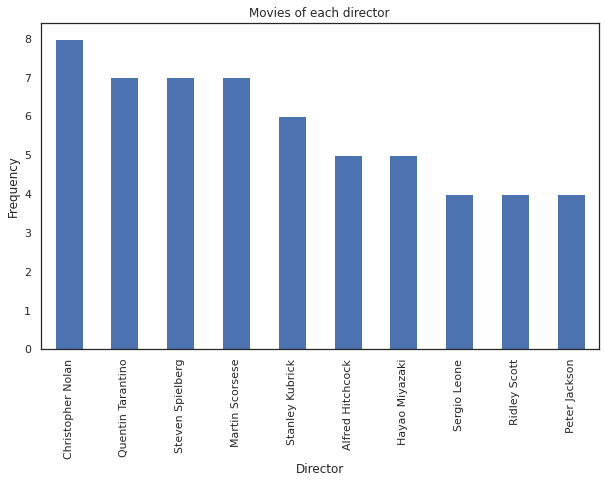

In [ ]:
ax = top_char_dir['director'].value_counts().head(10).plot(kind='bar',
                                    figsize=(10,6),
                                    title="Movies of each director")
ax.set_xlabel("Director")
ax.set_ylabel("Frequency")

# 4.Collaborative Filtering
* Collect user-item utilities
* Identify similar users
* Predict unknown item utilities based on other similar users

So far we focus on the data of movie. However, as a recommender system, it seems like something missing: what about data of each user? \
In this section, we will use a technique called **Collaborative Filtering** to make recommendations to Movie Watchers. Collaborative Filtering is based on the idea that users similar to me can be used to predict how much I will like a particular product or service those users have used/experienced but I have not. That means, Collaborative Filtering totally use data from users and doesn't consider about the similarity between movies.\
Here we will not implement Collaborative Filtering from scratch. Instead, we will use the **Surprise** library that used extremely powerful algorithms like **Singular Value Decomposition (SVD)** to minimise RMSE (Root Mean Square Error) and give great recommendations. But why SVD? The data we used is a matrix whose rows are userId, columns are movies and contents are ratings. We should notice that this will be a really sparse matrix, since one user would only rate for rarely movies. Thus we need to reduce the dimensionality of the matrix. 

In [ ]:
!pip install scikit-surprise

from surprise import Reader, Dataset, SVD, accuracy
from surprise.model_selection import cross_validate, train_test_split
reader = Reader()
svd = SVD()

In [ ]:
# An overview of users' ratings
user_ratings = pd.read_csv('gdrive/My Drive/recommendation system/the-movies-dataset/ratings_small.csv')
user_ratings

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205
...,...,...,...,...
99999,671,6268,2.5,1065579370
100000,671,6269,4.0,1065149201
100001,671,6365,4.0,1070940363
100002,671,6385,2.5,1070979663


In [ ]:
full_ratings = pd.read_csv('gdrive/My Drive/recommendation system/the-movies-dataset/ratings.csv')
full_ratings

,userId,movieId,rating,timestamp
0,1,110,1.0,1425941529
1,1,147,4.5,1425942435
2,1,858,5.0,1425941523
3,1,1221,5.0,1425941546
4,1,1246,5.0,1425941556
...,...,...,...,...
26024284,270896,58559,5.0,1257031564
26024285,270896,60069,5.0,1257032032
26024286,270896,63082,4.5,1257031764
26024287,270896,64957,4.5,1257033990


We can see that the full dataset of ratings is extremly huge, which will makes our algorithm's proccessing time become too long. So next we will use the ratings_small dataset which includes 100000 data. 

In [ ]:
# generate the data we will use later
user_data = Dataset.load_from_df(user_ratings[['userId', 'movieId', 'rating']], reader)

First, let's use the traditional train_test_split method  to sample a trainset and a testset with given sizes. After that, train a model and see the performance(represented by RMSE here) of the chosing model. 

In [ ]:
# split data to train set and test set, with fraction 8:2
trainset, testset = train_test_split(user_data, test_size=.2)

test_svd = SVD()
test_svd.fit(trainset)
predictions = test_svd.test(testset)
accuracy.rmse(predictions)

RMSE: 0.9007


0.9006808493882689

The RMSE is lower than 0.9, which is a good value. Now let's use a more reliable method - cross validation to see the performance of this algorithem:

In [ ]:
# Run 5-fold cross-validation and print results
cross_validate(svd, user_data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.8982  0.8989  0.9012  0.8958  0.8872  0.8962  0.0049  
MAE (testset)     0.6925  0.6900  0.6923  0.6909  0.6836  0.6898  0.0033  
Fit time          4.97    4.92    4.95    4.92    4.93    4.94    0.02    
Test time         0.39    0.19    0.16    0.16    0.41    0.26    0.11    


{'fit_time': (4.974740266799927,
  4.916883707046509,
  4.9503843784332275,
  4.919100522994995,
  4.933859348297119),
 'test_mae': array([0.69247272, 0.68999834, 0.69228239, 0.69088128, 0.68355652]),
 'test_rmse': array([0.89817333, 0.89893578, 0.90115369, 0.89576427, 0.88715554]),
 'test_time': (0.39098477363586426,
  0.18511319160461426,
  0.15926718711853027,
  0.15806365013122559,
  0.4053671360015869)}

The RMSE of this algorithm is still approximately 0.9, which is a really good value. It means this algorithm works well. Now let's start to train the model on whole dataset. 

In [ ]:
train_set = user_data.build_full_trainset()
svd.fit(train_set)

Now we have a model based on out users' dataset. Let's test how good our model work. To visualize the results, firstly we choose user 1 and see his/her ratings:

In [ ]:
user_ratings[user_ratings['userId'] == 1]

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205
5,1,1263,2.0,1260759151
6,1,1287,2.0,1260759187
7,1,1293,2.0,1260759148
8,1,1339,3.5,1260759125
9,1,1343,2.0,1260759131


We can see that user 1 rates movie 1029 of 3. What about the estimate score our model predict?

In [ ]:
svd.predict(1, 1029, r_ui = 3, verbose = True)

user: 1          item: 1029       r_ui = 3.00   est = 2.83   {'was_impossible': False}


Prediction(uid=1, iid=1029, r_ui=3, est=2.825902384611137, details={'was_impossible': False})

To have more insight, let's see the results from different user the model predict for the same movie:

In [ ]:
user_ratings[user_ratings['movieId'] == 1029][:10]

,userId,movieId,rating,timestamp
1,1,1029,3.0,1260759179
3363,19,1029,5.0,855192033
6508,35,1029,1.5,1174450070
9226,61,1029,2.5,1216487645
10390,73,1029,3.0,1256030424
15152,99,1029,3.0,938587916
15485,102,1029,5.0,958250063
19091,128,1029,4.0,1049691020
24155,175,1029,4.0,1052835824
25229,185,1029,3.0,1019787095


In [ ]:
svd.predict(19, 1029, r_ui = 5, verbose = True)

user: 19         item: 1029       r_ui = 5.00   est = 3.88   {'was_impossible': False}


Prediction(uid=19, iid=1029, r_ui=5, est=3.8833017107066423, details={'was_impossible': False})

In [ ]:
svd.predict(128, 1029, r_ui = 4, verbose = True)

user: 128        item: 1029       r_ui = 4.00   est = 4.08   {'was_impossible': False}


Prediction(uid=128, iid=1029, r_ui=4, est=4.077726968522822, details={'was_impossible': False})

So far, the predictions of our Collaborative Filtering seems good. We will use this algorithm as a part of the final algorithm.

# 5.Content-based Recommedation

Collaborative filtering doesn’t consider user or item attributes/content.

To personalize our recommendations more, we are going to build an engine that computes similarity (we choose **cosine similarity**) between movies based on certain metrics and suggests movies that are most similar to a particular movie that a user likes. For example, if a user gives a movie a high score, we immediately recommend a movie based this one. 

We will build two Content Based Recommenders based on:
* Movie Overviews 
* Movie Cast, Crew, Keywords and Genre



## Movie Overviews Based Recommedation


Notice that we are using a small dataset for our content-based recommedation algorithm. This smaller dataset contains 3785 "qualified" movie which are scored higher than **5.6** and contain at least **160** votes from users. The reason we are building this smaller dataset is we want to avoid "bad" movie when we are doing recommedation, which means those movies have bad rating or are not popular among users. 
 

In [ ]:
content_based_pd = cleaned_mv_pd.dropna(subset=['overview'])

In [ ]:
len(content_based_pd)

3785

In [ ]:
content_based_pd['overview'][0]

"Led by Woody, Andy's toys live happily in his room until Andy's birthday brings Buzz Lightyear onto the scene. Afraid of losing his place in Andy's heart, Woody plots against Buzz. But when circumstances separate Buzz and Woody from their owner, the duo eventually learns to put aside their differences."

In [ ]:
content_based_pd['overview'][1]

"When siblings Judy and Peter discover an enchanted board game that opens the door to a magical world, they unwittingly invite Alan -- an adult who's been trapped inside the game for 26 years -- into their living room. Alan's only hope for freedom is to finish the game, which proves risky as all three find themselves running from giant rhinoceroses, evil monkeys and other terrifying creatures."

### TF-IDF Transform
Once the text was processed, I converted it into features using
**Tfidfvectorizer** from sklearn.  

This vectorizer first calculates the **term frequency (TF)** 


**Term frequency** $tf_{t,d}$ is some measure of importance of term $t$ to document $d$. There are some ways to caculate term frequency.

* **Boolean**: $tf_{t,d} = 1$ if t occurs in d, 0 otherwise
* **Raw Counts**: $tf_{t,d} = c_{t,d}$, where  $c_{t,d}$ is the number of times t occurs in d
* **Log-Scaled Counts**: $tf_{t,d} = 1+logc_{t,d}, ifc_{t,d} >0$. This approach can reduces relative impact of frequent terms.
* **Normalized Counts**: $tf_{t,d} = \frac{c_{t,d}}{|d|} $. This approach normalize raw counts by length of document |d|

After compute the term frequency, we next need to compute the inverse term frequency. The idea behind this approach is that rare terms are more important than common terms. For example, if all training documents for a class contain the (relatively) common word “water”, and the (relatively) rare word “hippopotamus”, then the term “hippopotamus” is likely more important.

**Inverse Document Frequency** : $idf_{t,X} = log{\frac{|X|}{|X_t|+1}}$, Where X is the total set of documents, $X_t$ is the subset of documents containing term t.

After caculating both **Term frequency** and **Inverse Document Frequency**, we are going to the next step! To compensate for issues with raw word counts, use TF-IDF transform on the features with naïve Bayes: $tfidf_{t,d,X} = tf_{t,d} \times idf_{t,X} $, this feature represent document as a vector x of TF-IDF features




### Measure Similarity
After converting the content into TF-IDF features, we need to compare the similarity between different movies. There are many ways to measure similarity between different movies. Here we introduce three ways to do that.

* **Euclidean distance** : $similarty = \frac{1}{1+||x_u - x_v||^2}\in(0,1]$, one straightforward method to use as asimilarity metric
* **Cosine similarity** : $similarty = \frac{x_u x_v}{||x_u|| || x_v||}\in(0,1]$, another straightforward method to use as asimilarity metric
* **Pearson correlation** : $\rho = \frac{covariance(x_u,x_v)}{stdev(x_u)\times stdex(x_v)}$, it measures the linear correlatin between two utilities, value $\in [-1,1]$


**Euclidean distance** and **Cosine similarity** are straightforward as a similarity metric. Pearson correlation measures correalation between different movies' utilities, which allow it to handle different scale calibartions. **Pearson correlation** are useful for user's rating because some users may give higher overall scores than other users. For our problem, we choose cosine similarity as our metric. 

### Content-Based Algorithm

After introducing the TF-IDF feature and different similarity metric. Now we are going to build our content-based algorithm based on topic we introduced before. There are three steps for our content-based algorithm.

1. Compute Tf-idf feature of a movie
2. Compute cosine similarity between different movie
3. Compare the cosine similarity. The higher this score is, the more silimar two movies are.

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity

tf = TfidfVectorizer(analyzer='word',ngram_range=(1, 2),min_df=0, stop_words='english')
tfidf_matrix = tf.fit_transform(content_based_pd['overview'])
tfidf_matrix.shape

(3785, 106596)

Here we get a tfidf matrix, which is of shape 3785*106596. The first dimension represents there are 3785 movies in our qualified dataset. The second dimension is of size 106596, which means for a particular movie, we convert the movie overview into a vector of size 106596.

In [ ]:
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)
cosine_sim.shape

(3785, 3785)

Now we get a cosine_sim matrix, which is of shape 3785 * 3785. This matrix contains the cosine similarity score between each movie. For example, the first row of this matrix represents the cosine similarity score between the first movie and every other movie in our qualified dataset. In order to give the most relevant recomedation, we need to find the highest value of this row and thus finding the correspoding index of the movie.

In [ ]:
def content_based_recommedation(title, dataset, cosine_sim):
    # title: a string, which is the name of the movie
    # dataset: pandas dataframe which contains all the qualified movies
    # cosine_sim: numpy array which is the 
    dataset_pd = dataset.reset_index()
    titles = dataset_pd['title']
    indices = pd.Series(dataset_pd.index, index=dataset_pd['title'])
    idx = indices[title]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:10]
    movie_indices = [i[0] for i in sim_scores]
    return titles.iloc[movie_indices]

In [ ]:
content_based_recommedation('The Dark Knight Rises', cleaned_mv_pd, cosine_sim)

2054                            The Dark Knight
159                                      Batman
405                              Batman Returns
2394                 Batman: Under the Red Hood
2613                           Batman: Year One
3535                   Boruto: Naruto the Movie
2792    Batman: The Dark Knight Returns, Part 1
910                                         JFK
1688                              Batman Begins
Name: title, dtype: object

After implementing our recommedation algorithm. We are really excited to give it a try! If a user who really enjoyed the movie **The Dark Knight Rises**, our recommedation algorithm is able to identify it as a Batman film and consequently recommend other Batman films such as **The Dark Knight**, **Batman Returns** as its top recommendations. So far it seems so good!

But unfortunately, that is all this system can do at the moment. This is not of much use to most people as it doesn't take into considerations very important features such as cast, crew, director and genre, which determine the rating and the popularity of a movie. Someone who liked **The Dark Knight** probably likes it more because of the director **Nolan** and would hate **Batman Forever** and every other substandard movie in the Batman Series. Therefore, we are going to use much more suggestive information than **movie overview** . In the next section, we will build a more sophisticated recommedation system that takes **genre**, **keywords**, **cast** and **crew** into consideration.

## Cast, Crew, Genre, keywords Based Recommendation

To build our new recommedation system which is based on cast, crew, genre and keywords, we need to merge our current dataset with the crew and the keyword. And then we need to preprocess the data before we convert it to tf-idf feature. Let us prepare this data as our first step.


In [ ]:
credits = pd.read_csv('/content/gdrive/MyDrive/recommendation system/the-movies-dataset/credits.csv')
keywords = pd.read_csv('/content/gdrive/MyDrive/recommendation system/the-movies-dataset/keywords.csv')
keywords['id'] = keywords['id'].astype('int')
credits['id'] = credits['id'].astype('int')
cleaned_mv_pd['id'] = cleaned_mv_pd['id'].astype('int')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [ ]:
cleaned_mv_pd = cleaned_mv_pd.merge(credits, on='id')
cleaned_mv_pd = cleaned_mv_pd.merge(keywords, on='id')

In [ ]:
cleaned_mv_pd.head(1)

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count,genres_name,weighted_rating,cast,crew,keywords
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",21.9469,/rhIRbceoE9lR4veEXuwCC2wARtG.jpg,"[{'name': 'Pixar Animation Studios', 'id': 3}]","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0,"[Animation, Comedy, Family]",7.640253,"[{'cast_id': 14, 'character': 'Woody (voice)',...","[{'credit_id': '52fe4284c3a36847f8024f49', 'de...","[{'id': 931, 'name': 'jealousy'}, {'id': 4290,..."


Notice that now our **clean_mv_pd** has new features **cast, crew, keywords**. We are going to preprocess these features before we implement our content-based algorithm. For the information from **Crew:**, we will only pick the director as our feature since the director is the most important part of a movie and the director may be the main reason why people want to watch this movie. And for the information from **Cast:**. We know that lesser known actors and minor roles do not really affect people's opinion of a movie. We are interested in the leading actor and actress. Therefore, we should select the major characters and their respective actors. We will choose the top 5 actors that appear in the credits list. 

Then we use some trick dealing with these data. We **Convert to Lowercase** from all our features. This way, our engine will not confuse between **Johnny Depp** and **johnnydepp.** And we will **Mention Director 3 times** to give it more weight relative to the entire cast.

In [ ]:
cleaned_mv_pd['cast'] = cleaned_mv_pd['cast'].apply(literal_eval)
cleaned_mv_pd['crew'] = cleaned_mv_pd['crew'].apply(literal_eval)
cleaned_mv_pd['keywords'] = cleaned_mv_pd['keywords'].apply(literal_eval)
cleaned_mv_pd['cast_size'] = cleaned_mv_pd['cast'].apply(lambda x: len(x))
cleaned_mv_pd['crew_size'] = cleaned_mv_pd['crew'].apply(lambda x: len(x))

In [ ]:
cleaned_mv_pd.head(1)

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count,genres_name,weighted_rating,cast,crew,keywords,cast_size,crew_size
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",21.9469,/rhIRbceoE9lR4veEXuwCC2wARtG.jpg,"[{'name': 'Pixar Animation Studios', 'id': 3}]","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0,"[Animation, Comedy, Family]",7.640253,"[{'cast_id': 14, 'character': 'Woody (voice)',...","[{'credit_id': '52fe4284c3a36847f8024f49', 'de...","[{'id': 931, 'name': 'jealousy'}, {'id': 4290,...",13,106


In [ ]:
cleaned_mv_pd['director'] = cleaned_mv_pd['crew'].apply(get_director)

notice that we implement the function **get_dirctor** in previous section **2.4.8**, we can take adavantage of it here.

In [ ]:
cleaned_mv_pd['cast'] = cleaned_mv_pd['cast'].apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])
cleaned_mv_pd['cast'] = cleaned_mv_pd['cast'].apply(lambda x: x[:3] if len(x) >=3 else x)

In [ ]:
cleaned_mv_pd.head(1)

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count,genres_name,weighted_rating,cast,crew,keywords,cast_size,crew_size,director
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",21.9469,/rhIRbceoE9lR4veEXuwCC2wARtG.jpg,"[{'name': 'Pixar Animation Studios', 'id': 3}]","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0,"[Animation, Comedy, Family]",7.640253,"[Tom Hanks, Tim Allen, Don Rickles]","[{'credit_id': '52fe4284c3a36847f8024f49', 'de...","[{'id': 931, 'name': 'jealousy'}, {'id': 4290,...",13,106,John Lasseter


In [ ]:
cleaned_mv_pd['cast'] = cleaned_mv_pd['cast'].apply(lambda x: [str.lower(i.replace(" ", "")) for i in x])

In [ ]:
cleaned_mv_pd['director'] = cleaned_mv_pd['director'].astype('str').apply(lambda x: str.lower(x.replace(" ", "")))
cleaned_mv_pd['director'] = cleaned_mv_pd['director'].apply(lambda x: [x,x,x])

In [ ]:
cleaned_mv_pd.head(1)

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count,genres_name,weighted_rating,cast,crew,keywords,cast_size,crew_size,director
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",21.9469,/rhIRbceoE9lR4veEXuwCC2wARtG.jpg,"[{'name': 'Pixar Animation Studios', 'id': 3}]","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0,"[Animation, Comedy, Family]",7.640253,"[tomhanks, timallen, donrickles]","[{'credit_id': '52fe4284c3a36847f8024f49', 'de...","[{'id': 931, 'name': 'jealousy'}, {'id': 4290,...",13,106,"[johnlasseter, johnlasseter, johnlasseter]"


We will do a small amount of pre-processing of our keywords before putting them to any use. As a first step, we calculate the frequenct counts of every keyword that appears in the dataset.

In [ ]:
cleaned_mv_pd['keywords'] = cleaned_mv_pd['keywords'].apply(lambda x: [i.get('name') for i in x])
keywords = cleaned_mv_pd.apply(lambda x: pd.Series(x['keywords']),axis=1).stack().reset_index(level=1, drop=True)
keywords.name = 'keyword'

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  


In [ ]:
keywords = cleaned_mv_pd.apply(lambda x: pd.Series(x['keywords']),axis=1).stack().reset_index(level=1, drop=True)
keywords.name = 'keyword'

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  """Entry point for launching an IPython kernel.


In [ ]:
keywords_ct = keywords.value_counts()

In [ ]:
keywords_ct.head(20)

duringcreditsstinger    247
based on novel          229
murder                  192
woman director          179
violence                163
aftercreditsstinger     145
dystopia                141
biography               113
friendship              107
revenge                 106
teenager                105
love                    100
sequel                   97
independent film         93
prison                   88
police                   87
musical                  86
sport                    83
3d                       82
suspense                 79
Name: keyword, dtype: int64

In [ ]:
keywords_counter = Counter(keywords)

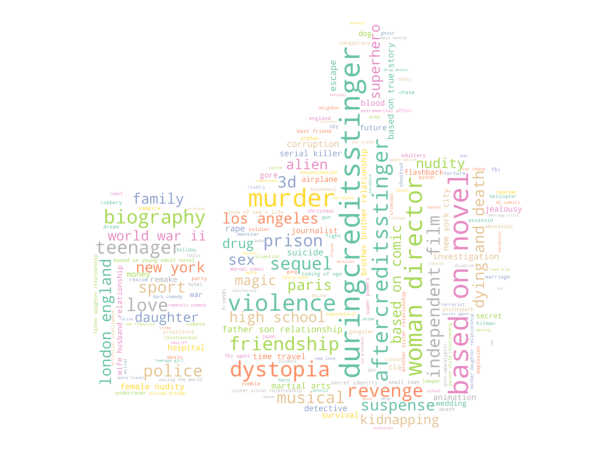

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
mask = np.array(Image.open('/content/gdrive/MyDrive/recommendation system/the-movies-dataset/upvote.png'))



highest_wordcloud = WordCloud(random_state=1,background_color='white', colormap='Set2', collocations=False,\
                              stopwords=stopwords,mask=mask).generate_from_frequencies(dict(keywords_counter))
plt.figure(figsize=(15,8))
plt.imshow(highest_wordcloud)
plt.axis("off")
plt.show()
plt.close()

From this table we can see Keywords occur in frequencies ranging from 1 to 247. We can see that some keywords like **based on novel**, **murder**, **woman director** are popular among all the movie.

In [ ]:
cleaned_mv_pd['keywords'] = cleaned_mv_pd['keywords'].apply(lambda x: [str.lower(i.replace(" ", "")) for i in x])

What We are going to do is creating a metadata combination for every movie which consists of **genres, director, main actors and keywords.** We then use a **Count Vectorizer** to create our count matrix as we did in the previous Recommender. The remaining steps are similar to what we did earlier: we calculate the cosine similarities and return movies that are most similar.

In [ ]:
cleaned_mv_pd['combine'] = cleaned_mv_pd['keywords'] + cleaned_mv_pd['cast'] + cleaned_mv_pd['director'] + cleaned_mv_pd['genres_name']
cleaned_mv_pd['combine'] = cleaned_mv_pd['combine'].apply(lambda x: ' '.join(x))

In [ ]:
cleaned_mv_pd.head(1)

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count,genres_name,weighted_rating,cast,crew,keywords,cast_size,crew_size,director,combine
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",21.9469,/rhIRbceoE9lR4veEXuwCC2wARtG.jpg,"[{'name': 'Pixar Animation Studios', 'id': 3}]","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0,"[Animation, Comedy, Family]",7.640253,"[tomhanks, timallen, donrickles]","[{'credit_id': '52fe4284c3a36847f8024f49', 'de...","[jealousy, toy, boy, friendship, friends, riva...",13,106,"[johnlasseter, johnlasseter, johnlasseter]",jealousy toy boy friendship friends rivalry bo...


In [ ]:
count = CountVectorizer(analyzer='word',ngram_range=(1, 2),min_df=0, stop_words='english')
count_matrix_1 = count.fit_transform(cleaned_mv_pd['combine'])
cosine_sim_1 = cosine_similarity(count_matrix_1, count_matrix_1)

In [ ]:
content_based_recommedation('The Dark Knight', cleaned_mv_pd, cosine_sim_1)

2654    The Dark Knight Rises
1701            Batman Begins
1874             The Prestige
722                 Following
3824                  Dunkirk
1240                 Insomnia
2401                Inception
1074                  Memento
3070             Interstellar
Name: title, dtype: object

We are more satisfied with the results we get this time. This algorithm seem to have recognized the director **Christopher Nolan** (due to the high weightage given to director) and took this factor into consideration rather than just recommended batman film. People may enjoy watching **The Dark Knight** as well as some of the other ones in the list including **Batman Begins**, **Inception** and **Interstellar**, which are the well-known movie by the director **Christopher Nolan**.

We can of course experiment on this engine by trying out different weights for our features (directors, actors, genres), limiting the number of keywords that can be used in the soup, weighing genres based on their frequency, only showing movies with the same languages, etc.

# Conclusion

In this project, we first built a top movie chart and then do some exploratory data analysis on this movie chart and other two datasets. Then we built our recommendation system upon two kind of recommedation algorithms: **collaborative filtering** and **content-based** recommedation. We mainly used Tfidfvectorizer to transform the data and cosine similarity to define the similarity of each film. The content-based recommendor system will take Movie Overviews, Cast, Crew, Keywords and Genre into consideration and generate more appropriate results. 